# Analysis Reference PEP

## Setup and Helper Functions

In [4]:
import re
import json

from pathlib import Path

import pandas as pd
import numpy as np
import pingouin as pg

from fau_colors import cmaps, register_fausans_font

import biopsykit as bp
from biopsykit.stats import StatsPipeline

import matplotlib.pyplot as plt
import seaborn as sns

from pepbench.io import load_challenge_results_from_folder
from pepbench.data_handling import get_reference_pep, describe_pep_values, get_pep_for_algo, get_reference_data, get_data_for_algo, compute_pep_performance_metrics
from pepbench.plotting.results import boxplot_reference_pep

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [5]:
#register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = "FAUSans Office"

palette

[(0.37254901960784315, 0.48627450980392156, 0.6392156862745098),
 (0.6666666666666666, 0.7647058823529411, 0.8196078431372549),
 (1.0, 0.8235294117647058, 0.44313725490196076),
 (0.37254901960784315, 0.7725490196078432, 0.9254901960784314),
 (0.5372549019607843, 0.803921568627451, 0.4745098039215686),
 (0.8627450980392157, 0.4117647058823529, 0.48627450980392156)]

In [6]:
root_path = Path("../../")

In [7]:
deploy_type = "local"

config_dict = json.load(root_path.joinpath("config.json").open(encoding="utf-8"))

empkins_base_path = Path(config_dict[deploy_type]["empkins_path"])
guardian_base_path = Path(config_dict[deploy_type]["guardian_path"])
print(empkins_base_path)

\Users\sebas\Development\ResearchInternship\Data\2024_08_PEP_Benchmarking\EmpkinS_Dataset


In [8]:
condition_mapping = {"tsst": "TSST", "ftsst": "f-TSST"}
phase_mapping = {"Prep": "Preparation", "Pause_1": "Pause 1", "Pause_5": "Pause 5", "Talk": "Talk", "Math": "Math"}

In [9]:
result_path = root_path.joinpath("results")

In [12]:
results = load_challenge_results_from_folder(result_path.joinpath("empkins_dataset_both_algorithms").resolve(), index_cols_per_sample=["participant", "condition", "phase"])

In [13]:
results.per_sample

heartbeat_id  \
                                                                                                       estimated   
q_wave_algorithm  b_point_algorithm   outlier_correction_algorithm participant condition phase                     
dwt-neurokit      multiple-conditions autoregression               VP_001      tsst      Prep    0             0   
                                                                                                 1             1   
                                                                                                 2             2   
                                                                                                 3             3   
                                                                                                 4             4   
...                                                                                                          ...   
r-peak-diff-42-ms third-derivative    none                         VP_032      ftsst     Pause_5 7             7   
                                                                                                 8             8   
                                                                                                 9             9   
                                                                                                 10           10   
                                                                                                 11           11   

                                                                                                               \
                                                                                                    reference   
q_wave_algorithm  b_point_algorithm   outlier_correction_algorithm participant condition phase                  
dwt-neurokit      multiple-conditions autoregression               VP_001      tsst      Prep    0          0   
                                                                                                 1          1   
                                                                                                 2          2   
                                                                                                 3          3   
                                                                                                 4          4   
...                                                                                                       ...   
r-peak-diff-42-ms third-derivative    none                         VP_032      ftsst     Pause_5 7          7   
                                                                                                 8          8   
                                                                                                 9          9   
                                                                                                 10        10   
                                                                                                 11        11   

                                                                                                    heartbeat_start_sample  \
                                                                                                                 estimated   
q_wave_algorithm  b_point_algorithm   outlier_correction_algorithm participant condition phase                               
dwt-neurokit      multiple-conditions autoregression               VP_001      tsst      Prep    0                     394   
                                                                                                 1                     984   
                                                                                                 2                    1569   
                                                                                                 3                    2134   
          

In [14]:
empkins_phase_order = ["Prep", "Pause_1", "Talk", "Math", "Pause_5"]
algo_levels = ["q_wave_algorithm", "b_point_algorithm", "outlier_correction_algorithm"]

In [15]:
reference_pep = get_reference_pep(results.per_sample)
reference_pep = reference_pep.reindex(results.per_sample.index.get_level_values("phase").unique(), level="phase")
reference_pep

pep_ms
participant condition phase             
VP_001      tsst      Prep    0       67
                              1       50
                              2       76
                              3       91
                              4       80
...                                  ...
VP_032      ftsst     Pause_5 7      146
                              8      154
                              9      154
                              10     158
                              11     148

[5000 rows x 1 columns]

In [16]:
describe_pep_empkins = describe_pep_values(reference_pep, group_cols=["condition", "phase"])
describe_pep_empkins.reindex(empkins_phase_order, level="phase")

pep_ms                        
                         mean        std   min    max
condition phase                                      
ftsst     Prep      87.954173  24.358548  33.0  167.0
          Pause_1   78.853881  20.669896  27.0  165.0
          Talk      93.879518  24.665924  26.0  180.0
          Math      94.588323  25.698978  27.0  163.0
          Pause_5  111.494737  21.279880  32.0  161.0
tsst      Prep      81.689605  21.447959  27.0  187.0
          Pause_1   76.610860  21.789336  30.0  150.0
          Talk      85.704516  28.384025  27.0  266.0
          Math      84.865183  20.616930  31.0  144.0
          Pause_5   99.214634  22.550222  52.0  161.0

In [17]:
get_reference_data(results.per_sample)

heartbeat_id  heartbeat_start_sample  \
participant condition phase                                              
VP_001      tsst      Prep    0              0                     399   
                              1              1                     985   
                              2              2                    1569   
                              3              3                    2134   
                              4              4                    2684   
...                                        ...                     ...   
VP_032      ftsst     Pause_5 7              7                    5864   
                              8              8                    6660   
                              9              9                    7458   
                              10            10                    8267   
                              11            11                    9074   

                                  heartbeat_end_sample  q_wave_onset_sample  \
participant condition phase                                                   
VP_001      tsst      Prep    0                    985                  567   
                              1                   1569                 1156   
                              2                   2134                 1735   
                              3                   2684                 2291   
                              4                   3227                 2846   
...                                                ...                  ...   
VP_032      ftsst     Pause_5 7                   6660                 6110   
                              8                   7458                 6900   
                              9                   8267                 7701   
                              10                  9074                 8515   
                              11                  9877                 9319   

                                  b_point_sample  pep_sample  pep_ms  \
participant condition phase                                            
VP_001      tsst      Prep    0              634          67      67   
                              1             1206          50      50   
                              2             1811          76      76   
                              3             2382          91      91   
                              4             2926          80      80   
...                                          ...         ...     ...   
VP_032      ftsst     Pause_5 7             6256         146     146   
                              8             7054         154     154   
                              9             7855         154     154   
                              10            8673         158     158   
                              11            9467         148     148   

                                  nan_reason  
participant condition phase                   
VP_001      tsst      Prep    0          NaN  
                              1          NaN  
                              2          NaN  
                              3          NaN  
                              4          NaN  
...                                      ...  
VP_032      ftsst     Pause_5 7          NaN  
                              8          NaN  
                              9          NaN  
                              10         NaN  
                              11         NaN  

[5000 rows x 8 columns]

In [18]:
describe_pep_empkins = describe_pep_values(reference_pep, group_cols=["condition", "phase"])
describe_pep_empkins.reindex(empkins_phase_order, level="phase")

pep_ms                        
                         mean        std   min    max
condition phase                                      
ftsst     Prep      87.954173  24.358548  33.0  167.0
          Pause_1   78.853881  20.669896  27.0  165.0
          Talk      93.879518  24.665924  26.0  180.0
          Math      94.588323  25.698978  27.0  163.0
          Pause_5  111.494737  21.279880  32.0  161.0
tsst      Prep      81.689605  21.447959  27.0  187.0
          Pause_1   76.610860  21.789336  30.0  150.0
          Talk      85.704516  28.384025  27.0  266.0
          Math      84.865183  20.616930  31.0  144.0
          Pause_5   99.214634  22.550222  52.0  161.0

In [19]:
get_data_for_algo(results.per_sample, ("r-peak-diff-40-ms", "straight-line", "autoregression"))

heartbeat_id            \
                                    estimated reference   
participant condition phase                               
VP_001      tsst      Prep    0             0         0   
                              1             1         1   
                              2             2         2   
                              3             3         3   
                              4             4         4   
...                                       ...       ...   
VP_032      ftsst     Pause_5 7             7         7   
                              8             8         8   
                              9             9         9   
                              10           10        10   
                              11           11        11   

                                 heartbeat_start_sample            \
                                              estimated reference   
participant condition phase                                         
VP_001      tsst      Prep    0                     394       399   
                              1                     984       985   
                              2                    1569      1569   
                              3                    2134      2134   
                              4                    2684      2684   
...                                                 ...       ...   
VP_032      ftsst     Pause_5 7                    5864      5864   
                              8                    6660      6660   
                              9                    7458      7458   
                              10                   8267      8267   
                              11                   9074      9074   

                                 heartbeat_end_sample            \
                                            estimated reference   
participant condition phase                                       
VP_001      tsst      Prep    0                   984       985   
                              1                  1569      1569   
                              2                  2134      2134   
                              3                  2684      2684   
                              4                  3227      3227   
...                                               ...       ...   
VP_032      ftsst     Pause_5 7                  6660      6660   
                              8                  7458      7458   
                              9                  8267      8267   
                              10                 9074      9074   
                              11                 9878      9877   

                                 q_wave_onset_sample           b_point_sample  \
                                           estimated reference      estimated   
participant condition phase                                                     
VP_001      tsst      Prep    0                561.0       567          656.0   
                              1               1151.0      1156         1230.0   
                              2               1732.0      1735         1825.0   
                              3               2289.0      2291         2394.0   
                              4               2835.0      2846         2937.0   
...                                              ...       ...            ...   
VP_032      ftsst     Pause_5 7               6106.0      6110         6272.0   
                              8               6897.0      6900         7064.0   
                              9               7699.0      7701         7866.0   
                              10              8511.0      8515         8677.0   
                              11              9315.0      9319         9483.0   

                                           rr_interval_ms pep_sample  \
                                 reference      estimated  estimated   
participant condition

In [20]:
get_pep_for_algo(results.per_sample, ("r-peak-diff-40-ms", "straight-line", "autoregression"))

pep_ms
participant condition phase             
VP_001      tsst      Prep    0     95.0
                              1     79.0
                              2     93.0
                              3    105.0
                              4    102.0
...                                  ...
VP_032      ftsst     Pause_5 7    166.0
                              8    167.0
                              9    167.0
                              10   166.0
                              11   168.0

[5000 rows x 1 columns]

In [21]:
describe_pep_values(results.per_sample[[("pep_ms", "estimated")]], group_cols=algo_levels)

pep_ms  \
                                                                     estimated   
                                                                          mean   
q_wave_algorithm  b_point_algorithm   outlier_correction_algorithm               
dwt-neurokit      multiple-conditions autoregression                 76.863445   
                                      linear-interpolation           77.483620   
                                      none                           72.872482   
                  second-derivative   autoregression                 91.705198   
                                      linear-interpolation           92.190437   
...                                                                        ...   
r-peak-diff-42-ms straight-line       linear-interpolation          111.598628   
                                      none                          108.775354   
                  third-derivative    autoregression                122.087149   
                                      linear-interpolation          122.689655   
                                      none                          118.044058   

                                                                               \
                                                                                
                                                                          std   
q_wave_algorithm  b_point_algorithm   outlier_correction_algorithm              
dwt-neurokit      multiple-conditions autoregression                34.675796   
                                      linear-interpolation          34.895039   
                                      none                          33.021508   
                  second-derivative   autoregression                31.224913   
                                      linear-interpolation          31.329120   
...                                                                       ...   
r-peak-diff-42-ms straight-line       linear-interpolation          23.714474   
                                      none                          24.459996   
                  third-derivative    autoregression                24.028846   
                                      linear-interpolation          23.596777   
                                      none                          27.210120   

                                                                          \
                                                                           
                                                                     min   
q_wave_algorithm  b_point_algorithm   outlier_correction_algorithm         
dwt-neurokit      multiple-conditions autoregression                 0.0   
                                      linear-interpolation           0.0   
                                      none                           0.0   
                  second-derivative   autoregression                21.0   
                                      linear-interpolation           5.0   
...                                                                  ...   
r-peak-diff-42-ms straight-line       linear-interpolation           5.0   
                                      none                           8.0   
                  third-derivative    autoregression                 2.0   
                                      linear-interpolation           4.0   
                                      none                           0.0   

                                                                           
                                                                           
                                                                      max  
q_wave_algorithm  b_point_algorithm   outlier_correction_algorithm         
dwt-neurokit      multiple-conditions autoregression                406.0  
                                      linear-interpolation          399.0  
                            

In [22]:
compute_pep_performance_metrics(results.per_sample, num_heartbeats=results.agg_total)

Mean Absolute Error [ms]  \
                                                                                     mean   
q_wave_algorithm  b_point_algorithm outlier_correction_algorithm                            
r-peak-diff-42-ms second-derivative none                                        14.467422   
r-peak-diff-40-ms second-derivative none                                        14.543691   
r-peak-diff-38-ms second-derivative none                                        14.870996   
r-peak-diff-36-ms second-derivative none                                        15.431031   
r-peak-diff-32-ms straight-line     none                                        15.642756   
...                                                                                   ...   
r-peak-diff-40-ms third-derivative  autoregression                              32.796853   
r-peak-diff-42-ms third-derivative  none                                        32.974535   
r-peak-diff-40-ms third-derivative  linear-interpolation                        33.164146   
r-peak-diff-42-ms third-derivative  autoregression                              34.722614   
                                    linear-interpolation                        35.106070   

                                                                             \
                                                                        std   
q_wave_algorithm  b_point_algorithm outlier_correction_algorithm              
r-peak-diff-42-ms second-derivative none                          19.624662   
r-peak-diff-40-ms second-derivative none                          19.148996   
r-peak-diff-38-ms second-derivative none                          18.676884   
r-peak-diff-36-ms second-derivative none                          18.210585   
r-peak-diff-32-ms straight-line     none                          14.773296   
...                                                                     ...   
r-peak-diff-40-ms third-derivative  autoregression                18.692504   
r-peak-diff-42-ms third-derivative  none                          17.856495   
r-peak-diff-40-ms third-derivative  linear-interpolation          18.837260   
r-peak-diff-42-ms third-derivative  autoregression                18.707778   
                                    linear-interpolation          18.850435   

                                                                 Mean Error [ms]  \
                                                                            mean   
q_wave_algorithm  b_point_algorithm outlier_correction_algorithm                   
r-peak-diff-42-ms second-derivative none                               -5.056657   
r-peak-diff-40-ms second-derivative none                               -3.056657   
r-peak-diff-38-ms second-derivative none                               -1.056657   
r-peak-diff-36-ms second-derivative none                                0.943343   
r-peak-diff-32-ms straight-line     none                              -10.363710   
...                                                                          ...   
r-peak-diff-40-ms third-derivative  autoregression                    -31.649385   
r-peak-diff-42-ms third-derivative  none                              -29.573161   
r-peak-diff-40-ms third-derivative  linear-interpolation              -32.267998   
r-peak-diff-42-ms third-derivative  autoregression                    -33.649385   
                                    linear-interpolation              -34.267998   

                                                                             \
                                                                        std   
q_wave_algorithm  b_point_algorithm outlier_correction_algorithm              
r-peak-diff-42-ms second-derivative none                          23.851707   
r-peak-diff-40-ms second-derivative none                          23.851707   
r-peak-diff-38-ms second-derivative none                          23.851707   
r-pe

In [23]:
steps = [("test", "rm_anova"), ("posthoc", "pairwise_tests")]
params = {
    "dv": "pep_ms",
    "within": ["phase", "condition"],
    "subject": "participant",
    "parametric": False,
}

pipeline = StatsPipeline(
    steps=steps,
    params=params,
)

pipeline.apply(reference_pep);
pipeline.display_results()

<font size="3"><b> Overview </b></font>

,dv,within,subject,parametric
parameter,pep_ms,"['phase', 'condition']",participant,False


,test,posthoc
parameter,rm_anova,pairwise_tests


<font size="3"><b> Statistical Tests </b></font>

**Repeated-measurement ANOVA**

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,phase,11478.813335,4,56,2869.703334,19.387876,0.0000,2.609264e-07,0.181712,0.659515
1,condition,1879.481799,1,14,1879.481799,5.015336,0.0419,4.187475e-02,0.035084,1.000000
2,phase * condition,398.365912,4,56,99.591478,1.419752,0.2394,2.459810e-01,0.007648,0.853593


<font size="3"><b> Post-Hoc Analysis </b></font>

**Pairwise Tests**

,Contrast,phase,A,B,Paired,Parametric,W-val,alternative,p-unc,hedges
0,phase,-,Math,Pause_1,True,False,4.0,two-sided,0.0004,0.719252
1,phase,-,Math,Pause_5,True,False,4.0,two-sided,0.0004,-0.839872
2,phase,-,Math,Prep,True,False,33.0,two-sided,0.1354,0.268737
3,phase,-,Math,Talk,True,False,60.0,two-sided,1.0000,-0.029309
4,phase,-,Pause_1,Pause_5,True,False,0.0,two-sided,0.0001,-1.489517
5,phase,-,Pause_1,Prep,True,False,18.0,two-sided,0.0151,-0.404574
6,phase,-,Pause_1,Talk,True,False,2.0,two-sided,0.0002,-0.680593
7,phase,-,Pause_5,Prep,True,False,3.0,two-sided,0.0003,1.042142
8,phase,-,Pause_5,Talk,True,False,5.0,two-sided,0.0006,0.748071
9,phase,-,Prep,Talk,True,False,25.0,two-sided,0.0479,-0.274017


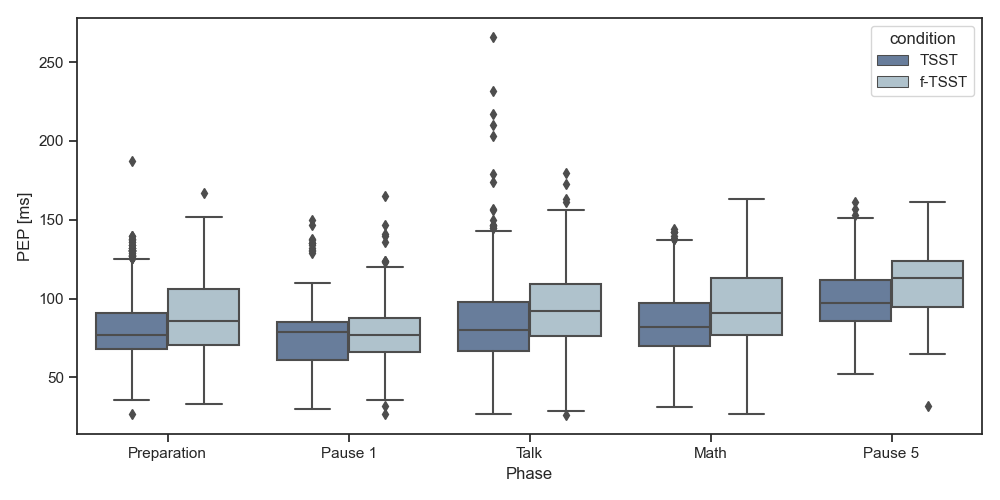

In [25]:
fig, ax = plt.subplots()

data_plot = reference_pep.rename(condition_mapping, level="condition").rename(phase_mapping, level="phase")
boxplot_reference_pep(data_plot, x="phase", y="pep_ms", hue="condition", ax=ax)

fig.tight_layout()